In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import randint
import DiscreteCondEnt as DC

In [58]:
low, high, RVsize, numRV = 0, 1, 1000, 3
depend = np.array([0, 1])
rv = DC.getRandomVar_select(np.random.uniform, low, high, RVsize, numRV, depend)

[[0.40857816 0.12898502 0.64815199 ... 0.4330561  0.77680143 0.68277074]
 [0.60260943 0.44567753 0.52663571 ... 0.71952792 0.43105842 0.45784743]
 [0.01118759 0.57466254 0.17478769 ... 0.15258403 0.20785984 0.14061818]]


In [59]:
from sklearn.metrics import mean_squared_error
def logMSEscorer(clf, X, y):
    y_est = clf.predict(X)
    return mean_squared_error(y, y_est)

In [60]:
def varEntropy(y):
    return np.var(y)

In [61]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=numRV)

CVFold = 3
Entropy = DC.computeEnt(rv, regressor,logMSEscorer, varEntropy, CVFold)

3  Discrete RVs with range [ 0.0001784465853386097 ,  0.9992909494649995 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.11400639761444879
0 	 [2] 	 0.11072181826710008
0 	 [2 1] 	 0.012130421105304693
1 	 [0] 	 0.10235033551504048
1 	 [2] 	 0.10441765047704411
1 	 [2 0] 	 0.013827286734525782
2 	 [0] 	 0.10959202050242783
2 	 [1] 	 0.11538385517082365
2 	 [1 0] 	 0.015023402645676831


In [62]:
Entropy

array([[0.08411174, 0.1140064 , 0.11072182, 0.01213042],
       [0.08099188, 0.10235034, 0.10441765, 0.01382729],
       [0.08168811, 0.10959202, 0.11538386, 0.0150234 ]])

In [63]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()

In [64]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,1],[1,1]],
                                 size = 300)
x = np.transpose(x)

In [65]:
RVszie = 300
numRV =2
DEntropy = DC.computeEnt(x, linReg, logMSEscorer, varEntropy, CVFold)

2  Discrete RVs with range [ -3.5971375954033724 ,  2.5860788947179554 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 1.387730609746962e-31
1 	 [0] 	 1.013527279087011e-31


In [66]:
x2 = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)
x2 = np.transpose(x2)

In [67]:
RVszie = 300
numRV =2
DEntropy2 = DC.computeEnt(x2, linReg, logMSEscorer, varEntropy, CVFold)

2  Discrete RVs with range [ -3.3892440470042686 ,  2.811276996140177 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 1.0644300552361845
1 	 [0] 	 1.0259305382121273


In [68]:
DEntropy

array([[9.87655336e-01, 1.38773061e-31],
       [9.87655336e-01, 1.01352728e-31]])

In [69]:
#MI
MI12_1 = DEntropy[0,0] - DEntropy[0,1]
MI12_2 = DEntropy[1,0] - DEntropy[1,1]
print (MI12_1, MI12_2)

0.9876553358746256 0.987655335874625


In [72]:
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim

def build_cov_matrix(rho):
    return torch.tensor([
        [1, 0, 0, rho],
        [0, 1, rho, 0],
        [0, rho, 1, 0],
        [rho, 0, 0, 1]]
    ).float()


lr = 0.001
last_lr = 0.000001
batch_size = 128
total_iters = 2000
display_step = 400


def mi_theta(T, pos, neg):
    return T(pos).mean() - T(neg).exp().mean().log()

MINE = []
KNN = []
GT = []
COV = []

In [73]:
for i in range(19):
    cov = 0.1*i - 0.9
    COV.append(cov)
    #MINE=========================================================
    cov_matrix = build_cov_matrix(cov)
    X_ab = dist.MultivariateNormal(torch.zeros(4), cov_matrix)
    X_b = dist.MultivariateNormal(torch.zeros(2), cov_matrix[2:, 2:])

    # network
    T = nn.Sequential(
        nn.Linear(4, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

    plot_loss = []
    trainer = optim.SGD(T.parameters(), lr=lr, momentum=0.9)

    #print('==================rho:%.2f=================' % cov)
    for it in range(total_iters):
        xab_samples = X_ab.sample((batch_size,))
        xb_samples = X_b.sample((batch_size,))
        neg_samples = torch.cat([xab_samples[:, :2], xb_samples], -1)

        loss = - mi_theta(T, xab_samples, neg_samples)
        trainer.zero_grad()
        loss.backward()
        trainer.step()
        plot_loss.append(loss.item())

        update_lr = lr - (lr - last_lr) * display_step / total_iters
        for param_group in trainer.param_groups:
            param_group['lr'] = update_lr

        #if (it + 1) % display_step == 0:
            #print('[Iter: %d] [loss: %.3f]' % (it, sum(plot_loss[-display_step:]) / display_step))

    xab_test_samples = X_ab.sample((1000,))
    xb_test_samples = X_b.sample((1000,))
    neg_test_samples = torch.cat([xab_test_samples[:, :2], xb_test_samples], -1)
    mi = mi_theta(T, xab_test_samples, neg_test_samples).mean().item()
    MINE.append(mi)
    #print('===================mi:%.2f=================' % mi)
    #plt.scatter(cov, mi, c='b', label='MINE')
    #MINE=========================================================
    x = np.transpose(np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,cov],[cov,1]],
                                 size = 10000))
    DE = DC.computeEnt(x, linReg, logMSEscorer, varEntropy, CVFold)
    MI = DE[1,0] + DE[0,0] - DE[0,1] - DE[1,1]
    MI = MI/2
    KNN.append(MI)
    #plt.scatter(cov, MI, c='g',label='KNN-regressor')
    groundTruth = -0.5*np.log(1-cov*cov)
    GT.append(groundTruth)
    #plt.scatter(cov, groundTruth, c='r',label='ground truth')

#plt.legend()
#plt.show()

2  Discrete RVs with range [ -3.8863769695903305 ,  3.801712571255828 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.1908944530823021
1 	 [0] 	 0.19047052160354558
2  Discrete RVs with range [ -4.1066382244032855 ,  4.075174841188359 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.36011205346841324
1 	 [0] 	 0.3600017085334432
2  Discrete RVs with range [ -4.030722618194002 ,  3.5334246327127774 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.5198792483801896
1 	 [0] 	 0.5087190828664893
2  Discrete RVs with range [ -3.8425851477753845 ,  3.9346552343486496 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.6257939878937115
1 	 [0] 	 0.6580848896526562
2  Discrete RVs with range [ -4.002876308578944 ,  4.470676231667122 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.7294678381844689
1 	 [0] 	 0.7555802810381023
2  Discrete RVs with range [ -3.939632419268643 ,  3.6989318805852283 ]
Resp	Cond	H(Resp|Cond)
0 	 [1] 	 0.8510990113866747
1 	 [0] 	 0.8327112788811982
2  Discrete RVs with range [ -4.174868223058559 ,  3.637962083325097 ]
Resp	Cond

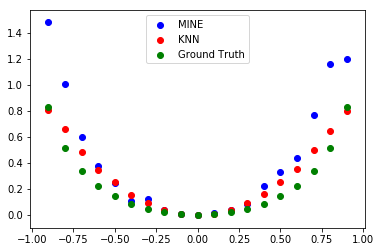

In [75]:
fig, ax = plt.subplots()

ax.scatter(COV, MINE, c='b', label='MINE')
ax.scatter(COV, KNN, c='r', label='KNN')
ax.scatter(COV, GT, c='g', label='Ground Truth')

ax.legend()
plt.show()